# Phân tích cảm xúc với LSTMs

Trong assignment này, chúng ta sẽ dùng mạng LSTM để giải quyết bài toán phân tích cảm xúc (Sentiment Analysis) trên tập dữ liệu văn bản. Nếu nhìn theo kiểu black box, đầu vào của bài toán là một câu hoặc đoạn văn bản và đầu ra là trạng thái tích cực, tiêu cực hay trung hoà (positive - negative - neutral). Trong phạm vi của assignment này, chúng ta chỉ quan tâm đến hai trạng thái cảm xúc là positive và negative.

![caption](Images/input_output.png)

# Góc nhìn Word Vectors

Nếu như chúng ta giữ nguyên định dạng đầu vào là chuỗi ký tự thì rất khó để thực hiện các thao tác biến đổi như tích vô hướng (dot product) hoặc các thuật toán trên mạng neural network như backpropagation. Thay vì dữ liệu đầu vào là một chuỗi, chúng ta cần chuyển đổi các từ trong tập từ điển sang dạng vector số học trong đó có thể thực hiện được các phép toán nêu trên.

![caption](Images/word2vec.png)

Trong hình minh hoạ ở trên, ta có thể hình dung dữ liệu đầu vào của thuật toán phân tích cảm xúc là một ma trận 16 x D chiều. Trong đó 16 là số lượng từ trong câu và D là số chiều của không gian vector để biểu diễn từ. Để ánh xạ từ một từ sang một vector, chúng ta sử dụng ma trận word embedding như đã thực hiện trong bài Lab 2.

## Tập dữ liệu

Trong assignment này, chúng tôi sử dụng tập dữ liệu review trên trang Foody với khoảng 30,000 mẫu được gán nhãn. Trong đó có 15,000 mẫu positive và 15,000 mẫu negative. Nguồn: https://streetcodevn.com/blog/dataset. Tập dữ liệu này đã được đính kèm trong thư mục của assignment 3.

## Các bước để huấn luyện trên mạng RNN

Có 5 bước chính để giải quyết bài toán phân tích cảm xúc trong văn bản:

    1) Huấn luyện một mô hình phát sinh ra vector từ (như mô hình Word2Vec) hoặc tải lên các vector từ tiền huấn luyện.
    2) Tạo ma trận ID cho tập dữ liệu huấn luyện
    3) Tạo mô hình RNN với các đơn vị LSTM, sử dụng tensorflow
    4) Huấn luyện mô hình RNN với dữ liệu ma trận đã tạo ở bước 2
    5) Đánh giá mô hình đã huấn luyện với tập test

# 1. Load tập từ vựng và ma trận word embedding

Đầu tiên, để có thể biến đổi một từ thành một vector, chúng ta sử dụng mô hình đã được huấn luyện trước đó (pretrained model). Mô hình đã train trước đó cho tiếng Việt được lấy ở đây: https://s3-us-west-1.amazonaws.com/fasttext-vectors/word-vectors-v2/cc.vi.300.vec.gz

Tuy nhiên, số lượng từ vựng tiếng Việt được huấn luyện rất lớn, khoảng 2M từ. Mỗi từ được biểu diễn dưới dạng một vector 300 chiều. Với kích thước gốc của ma trận word embedding như vậy sẽ gây khó khăn cho việc load dữ liệu cũng như đưa vào thư viện tensorflow để huấn luyện nên chúng tôi đã tối giản lại với số lượng từ tối thiểu để có thể chạy được trên tập dữ liệu review về đồ ăn của Foody.


In [33]:
import numpy as np
import os
# LƯU Ý: CẦN PHẢI CHỈNH LẠI ĐƯỜNG DẪN NÀY THÀNH THƯ MỤC CHỨA CÁC FILE ASSIGNMENT3
# CHỮ 'drive' có nghĩa là thư mục mặc định của Google drive
currentDir = '.'

wordsList = np.load(os.path.join(currentDir, 'wordsList.npy'))
print('Simplified vocabulary loaded!')
wordsList = wordsList.tolist()
#wordsList = [word.decode('UTF-8') for word in wordsList] #Encode words as UTF-8
wordVectors = np.load(os.path.join(currentDir, 'wordVectors.npy'))
wordVectors = np.float32(wordVectors)
print ('Word embedding matrix loaded!')

Simplified vocabulary loaded!
Word embedding matrix loaded!


Để chắc chắn mọi dữ liệu được load lên một cách chính xác, chúng ta cần kiểm tra xem số lượng từ trong từ điển rút gọn và số chiều của ma trận word embedding có khớp với nhau hay không? Trong trường hợp này số từ mà chúng tôi giữ lại là 19,899 và số chiều trong không gian biểu diễn là 300 chiều.

In [2]:
print('Size of the vocabulary: ', len(wordsList))
print('Size of the word embedding matrix: ', wordVectors.shape)

Size of the vocabulary:  19899
Size of the word embedding matrix:  (19899, 300)


## Word2Vec trên một từ đơn

Để có thể xác định được vector biểu diễn của một từ tiếng Việt. Đầu tiên chúng ta sẽ xác định xem vị trí của từ đó trong wordsList. Sau đó lấy vector ở dòng tương ứng trên trên ma trận wordVectors. 

In [3]:
ngon_idx = wordsList.index('ngon')
print('Index of `ngon` in wordsList: ', ngon_idx)
ngon_vec = wordVectors[ngon_idx]
print('Vector representation of `ngon` is: ', ngon_vec)

Index of `ngon` in wordsList:  14598
Vector representation of `ngon` is:  [-2.040e-02 -9.800e-03  2.290e-01 -3.770e-02  5.430e-02 -2.680e-02
  2.190e-02 -6.290e-02 -2.200e-02 -1.010e-02  8.300e-03 -8.810e-02
 -3.630e-02  7.820e-02 -7.780e-02 -4.930e-02 -6.600e-03 -1.026e-01
 -1.040e-02  5.380e-02  4.100e-02  6.530e-02 -2.770e-02 -6.340e-02
  2.270e-02  4.420e-02  3.340e-02 -4.960e-02  8.290e-02 -3.990e-02
  3.750e-02  1.800e-02 -1.115e-01 -7.200e-02 -5.060e-02 -1.051e-01
 -4.560e-02 -1.765e-01 -3.300e-02 -6.800e-03  5.580e-02 -4.180e-02
  4.380e-02  4.940e-02  7.400e-03  4.020e-02 -8.850e-02 -9.840e-02
 -5.210e-02 -5.500e-03  3.730e-02 -8.460e-02 -6.910e-02 -4.980e-02
 -3.910e-02 -4.980e-02 -8.690e-02  6.100e-03 -5.360e-02 -3.800e-03
  1.162e-01 -4.160e-02  5.000e-03 -7.240e-02 -3.320e-02  1.800e-02
  1.200e-02 -4.420e-02  1.350e-01  6.580e-02 -1.110e-02  1.960e-02
  1.750e-02  2.010e-02  2.200e-03  1.810e-01 -6.610e-02 -6.860e-02
 -4.690e-02  7.890e-02  6.880e-02 -5.320e-02  2.770e-02

### ToDo 3.1: Word2Vec để biểu diễn một đoạn văn bản

Nâng cấp hơn so với phiên bản Word2Vec cho từ đơn, phần này chúng ta sẽ biểu diễn một câu dưới dạng một ma trận gồm các vector biểu diễn của từng từ chồng lên nhau.

Ví dụ như chúng ta muốn biểu diễn câu "Món này ăn hoài không biết chán". Đầu tiên, với mỗi từ trong câu ta sẽ tìm chỉ số tương ứng trong từ điển và lưu vào vector đặt tên là 'sentenceIndexes'. Sau đó, chúng ta có thể sử dụng hàm tra cứu ma trận word embedding của thư viện Tensorflow tf.nn.embedding_lookup để tra các vector tại các chỉ số trong 'sentenceIndexes'. Như vậy nếu chúng ta sử dụng tối đa 10 từ để lưu trữ cho một câu thì ma trận biểu diễn cho câu sẽ là một ma trận kích thước 10 x 300.

![caption](Images/embedding.png)

In [34]:
import tensorflow as tf
maxSeqLength = 10   #Maximum length of sentence
numDimensions = 300 #Dimensions for each word vector
sentenceIndexes = np.zeros((maxSeqLength), dtype='int32')

# TODO 3.1: Gán chỉ số của các từ trong câu và 'sentenceIndexes'
sentence = 'Món này ăn hoài không biết chán'
for i, word in enumerate(sentence.split()):
    word = word.lower()
    if word in wordsList:
        sentenceIndexes[i] = wordsList.index(word)

# Các chỉ số 7, 8, 9 của sentenceIndexes  vẫn được gán bằng 0 như cũ
print(sentenceIndexes.shape)
print('Row index for each word: ', sentenceIndexes)

# Ma trận biểu diễn:
print('Sentence representation of word vectors:')
print(tf.nn.embedding_lookup(wordVectors,sentenceIndexes).shape)

(10,)
Row index for each word:  [  119  8136  4884 18791 16614 15951  3371     0     0     0]
Sentence representation of word vectors:
(10, 300)


Nếu như thực hiện đúng thì vector 'sentenceIndexes' sẽ có giá trị là: [119, 8136, 4884, 18791, 16614, 15951, 3371, 0, 0, 0]

# 2. Khảo sát tập dữ liệu huấn luyện và tạo ma trận ID

Trong assignment 3, chúng tôi sử dụng tập dữ liệu lấy từ trang web Foody trên miền dữ liệu liên quan đến ẩm thực. Tập dữ liệu bao gôm 15.000 review tích cực đặt trong thư mục 'positiveReviews' và 15.000 review tiêu cực đặt trong thư mục 'negativeReviews'. Do khối lượng dữ liệu lớn, nếu chúng ta chọn số lượng từ tối đa (maxSeqLength) quá cao thì sẽ bị lãng phí khi biểu diễn ở những câu review quá ngắn. Ngược lại, nếu sử dụng số lượng từ tối đa quá ít thì sẽ bị bỏ lỡ những từ quan trọng giúp cho việc phân tích cảm xúc.



In [2]:
from os import listdir
from os.path import isfile, join
positiveFiles = ['positiveReviews/' + f for f in listdir('positiveReviews/') if isfile(join('positiveReviews/', f))]
negativeFiles = ['negativeReviews/' + f for f in listdir('negativeReviews/') if isfile(join('negativeReviews/', f))]
numWords = []
for pf in positiveFiles:
    with open(pf, "r", encoding='utf-8') as f:
        line=f.readline()
        counter = len(line.split())
        numWords.append(counter)       
print('Positive files finished')

for nf in negativeFiles:
    with open(nf, "r", encoding='utf-8') as f:
        line=f.readline()
        counter = len(line.split())
        numWords.append(counter)  
print('Negative files finished')

numFiles = len(numWords)
print('The total number of files is', numFiles)
print('The total number of words in the files is', sum(numWords))
print('The average number of words in the files is', sum(numWords)/len(numWords))

Positive files finished
Negative files finished
The total number of files is 30000
The total number of words in the files is 1770824
The average number of words in the files is 59.02746666666667


Chúng ta có thể sử dụng thư viện Matplot để minh hoạ phân bố về chiều dài của các câu review trong tập dữ liệu:

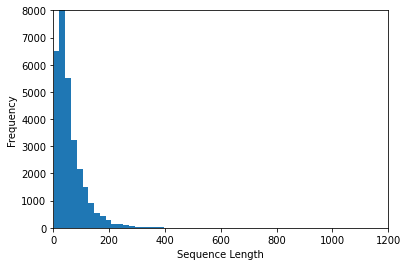

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(numWords, 50)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.axis([0, 1200, 0, 8000])
plt.show()

Dựa trên biểu đồ histogram ở trên chúng ta có thể thấy là 180 là kết quả tương đối hợp lý. 

In [39]:
maxSeqLength = 180

Để có cảm nhận rõ hơn về dữ liệu, chúng ta có thể hiển thị một số review bất kỳ như sau.

In [8]:
print('A positive sentence: ')
fname = positiveFiles[3] # Randomly select a positive file to view
with open(fname, encoding='utf-8') as f:
    for lines in f:
        print(lines)

print('A negative sentence: ')
fname = negativeFiles[10] # Randomly select a negative file to view
with open(fname, encoding='utf-8') as f:
    for lines in f:
        print(lines)


A positive sentence: 
Minh đến đây là vì nhân_viên ở đây . Lúc mình đến thì tối muộn rồi mà khách vẫn đông người mà toàn mấy bạn nữ ( chắc giống mình ) . Mình gọi trà matcha óc chó và cực_kì hài_lòng . Vì mình đến lúc đông khách nên cảm_giác hơi bí nhưng không_gian đẹp và nhân_viên thì trên cả tuyệt_vời . Từ nhân_viên gửi xe đến dọn_dẹp hay pha_chế đều thân_thiện , dễ_thương .

A negative sentence: 
Điạ điễm mình yêu thíc và thường_xuyên ghé . Stố ngon li bự , có trái_cây đễ lên trên nên nhìn đẹp và hấp_dẫn , mình uống thường mix các loại vs nhau nên lúc_nào cũng thấy ngon 😙 giá_cả cũng đc , có Wi-Fi nhưng hơi yếu . Chỉ ghét là giữ xe 10k , lễ lộc là 20k 😫 mua về thì chỗ_đứng hơi hẹp , ngồi uống cũng v hơi chật do ngồi sát 2bên hẽm đễ chừa đg cho xe và ng ra_vào . Nằm trong khu Bùi viện lên lúc_nào cũng tấp_nập đông vui 👍



## Chuẩn hoá văn bản và tách từ

Để tiết kiệm công sức và cũng nằm ngoài phạm vi của khoá học, chúng tôi đã chuẩn bị sẵn tập dữ liệu đã được tách từ. Giữa hai từ có thể ghép lại để tạo thành một khái niệm mới chúng tôi sử dụng ký tự '_' để nối các từ đó. Ví dụ: 'sinh_viên', 'sinh_học'.

Chúng tôi chuẩn bị sẵn các hàm chuẩn hoá văn bản nhằm loại bỏ các ký tự đặc biệt. Tham khảo ở hàm 'cleanSentences'.

In [3]:
# Removes punctuation, parentheses, question marks, etc., and leaves only alphanumeric characters
import re
strip_special_chars = re.compile("[^\w0-9 ]+")

def cleanSentences(string):
    string = string.lower().replace("<br />", " ")
    return re.sub(strip_special_chars, "", string.lower())

Bây giờ chúng ta sẽ biểu diễn 30.000 review dưới dạng các chỉ số của các từ. Tập dữ liệu positive và negative sẽ được tính hợp lại thành một ma trận 30000x180. Trong đó 30000 là số lượng review và 180 là số lượng từ tối đa cho một câu. Do bước chuẩn bị này tốn khá nhiều tài nguyên tính toán nên sau khi tính toán xong, chúng ta sẽ lưu lại để sử dụng cho những lần chạy thí nghiệm sau. Ma trận lưu trữ các chỉ số này là: 'ids'.

### ToDo 3.2: xác định chỉ số của từng từ trong review

Trong phần này chúng ta sẽ tiến hành tra cứu từng từ trong review, sau đó gán vào ma trận 'ids'. Trong đó chỉ số dòng của ma trận tương ứng với file review, chỉ số cột của ma trận tương ứng với một từ của review. Trường hợp từ nào không có trong tập từ điển thì ta sẽ gán bằng chỉ số của từ 'UNK' (unknow).

In [5]:
positiveFiles[:5]

['positiveReviews/27034.txt',
 'positiveReviews/30572.txt',
 'positiveReviews/414.txt',
 'positiveReviews/3350.txt',
 'positiveReviews/4288.txt']

In [26]:
ids = np.zeros((numFiles, maxSeqLength), dtype='int32')
nFiles = 0
# Index of Unknow word
unk_idx = wordsList.index('UNK')

for pf in positiveFiles:
    with open(pf, "r", encoding="utf-8") as f:
        nIndexes = 0
        lines=f.readlines()
        flag_max = False
        for line in lines:
            cleanedLine = cleanSentences(line)
            split = cleanedLine.split()
        
            for word in split:
                # TODO 3.2: Nếu 'word' thuộc tập 'wordsList' thì gán chỉ số của 'word' vào ma trận ids
                if word in wordsList:
                    ids[nFiles][nIndexes] = wordsList.index(word)
                else:
                    ids[nFiles][nIndexes] = unk_idx
                # Ngược lại: gán 'unk_idx' vào ma trận ids
            
                nIndexes = nIndexes + 1
                if nIndexes >= maxSeqLength:
                    flag_max = True
                    break
            if flag_max:
                break
        nFiles = nFiles + 1 

print('Positive files are indexed!')
for pf in negativeFiles:
    with open(pf, "r", encoding="utf-8") as f:
        nIndexes = 0
        lines=f.readlines()
        flag_max = False
        for line in lines:
            cleanedLine = cleanSentences(line)
            split = cleanedLine.split()
        
            for word in split:
                # TODO 3.2: Nếu 'word' thuộc tập 'wordsList' thì gán chỉ số của 'word' vào ma trận ids
                if word in wordsList:
                    ids[nFiles][nIndexes] = wordsList.index(word)
                else:
                    ids[nFiles][nIndexes] = unk_idx
                # Ngược lại: gán 'unk_idx' vào ma trận ids
            
                nIndexes = nIndexes + 1
                if nIndexes >= maxSeqLength:
                    flag_max = True
                    break
            if flag_max:
                break
        nFiles = nFiles + 1

print('Negative files are indexed!')
# Save ids Matrix for future uses.
np.save(os.path.join(currentDir,'idsMatrix.npy'), ids)

Positive files are indexed!
Negative files are indexed!


In [40]:
# LƯU Ý: Bước thực hiện trên tương đối mất thời gian.
# Trường hợp đã tính toán và lưu ma trận 'ids' rồi thì ta có thể load lên để sử dụng luôn
ids = np.load(os.path.join(currentDir,'idsMatrix.npy'))
print('Word indexes of the first review: ', ids[0])


Word indexes of the first review:  [11975  8136 17108 13863  5596 14855  5596   799 10774  4884 11975 14753
 14794  1825 10774 12615 14855  4711  8031   880  2616  8262 10630  4558
  5446  2465  3364  4639  6708  6521 11440 17292  4135  4957 17330 12145
 18393 15387 16760 14017 16521  6244 10231  7692 11440 14341   547 14475
  2223  7087 18393  7424 18655  9673 11068 14595 10139 11440 19646 10453
 11975  4558 15444 18407 19363 16624  3364 14017 16521  8884  1906 17821
 15522   547  1868 12145 18503  1906  6512  9704  2997 11068 14598 15570
  5596 13258  4884 16995  6512  9704  6874 12990 11047 10346 17162  6915
 18584  4884 17130  2611 18503 16995  4711 12990 12145  1047  1731 13315
  8880 14017 16521 16807 19261 16346  6512  9704  6512  9704 17572  6874
  8231  1368 19193  9673  4682  8231  1238  4558   294  5596 11440 16812
  1450  2451  1807   495  1346  1807 16995  6512  9704  8548  5596 13255
  7836 15605  5767 17636  1868 11966  5013  4236 18655   119  4884 10009
 15341  1074  27

In [41]:
s = ''
for w in ids[0]:
  s += wordsList[w]
  s += ' '
s

'quán này gần nhà mình nên mình hay đến ăn quán mở_cửa từ sáng đến tối nên hk sợ canh giờ_giấc không_gian thoáng có máy_lạnh mát lắm lun khá yên_tĩnh đi đông nói_chuyện ồn quá thì hơi kì vì ở đây đa_số ng ta đi uống cafe làm_việc học bài hơi yên_lặng trang_trí lịch_sự cực sạch_sẽ nếu đi chiều chiều_tối quán có mở nhạc_nhẹ nghe phê lắm ở đây ngoài bán kem và cafe ra thì còn bán mỳ ý nữa cực ngon nhé mình thường ăn phần mỳ ý bò phô_mai dành cho các bạn thích ăn béo_béo 42k còn phần hk phô_mai thì rẻ hơn giá_cả phù_hợp ở đây menu đủ kiểu mỳ ý mỳ ý gà bò phục_vụ tốt thân_thiện lịch_sự thời_gian phục_vụ nhanh có kỳ mình đi zs bạn_bè tổng_cộng 6 đứa kêu 6 phần mỳ ý tụi mình ngồi nc tí là đem ra liền à cách trang_trí món ăn bắt_mắt trà đá free kem ngon còn cafe ở đây mình chưa uống vị_trí trong hẻm nói là trong hẻm chứ hẻm cũng bự nên '

Nếu như quá trình chuyển từ câu dạng văn bảng sang vector các chỉ số trong từ điển ở trên đúng thì ids[0] sẽ nhận giá trị: [19898  1906  4454  5284 10661 11694 11994 18784 18569 18619 13174  9821 ...]

## Xây dựng hàm lấy dữ liệu train và test theo từng batch

Dưới đây chúng tôi xây dựng các hàm để lấy dữ liệu train và test theo từng batch. Bạn hãy giải thích tại sao lại có các con số 13999, 14999, 15999, 29999 nhé.

In [36]:
from random import randint

def getFullData():
    train_y = []
    test_y = []
    train_x = np.zeros([28000, maxSeqLength])
    test_x = np.zeros([2000, maxSeqLength])
    train_num = 0
    test_num = 0
    
    for i in range(30000):    
        if i < 14000:
            train_y.append(1)
            train_x[train_num] = ids[i:i+1]
            train_num += 1
            
        elif i >= 14000 and i <15000:
            test_y.append(1)
            test_x[test_num] = ids[i:i+1]
            test_num += 1
            
        elif i >= 15000 and i < 16000:
            test_y.append(0)
            test_x[test_num] = ids[i:i+1]
            test_num += 1
            
        elif i >= 16000:
            train_y.append(0)
            train_x[train_num] = ids[i:i+1]
            train_num += 1
    return train_x, np.array(train_y), test_x, np.array(test_y)
        

# 3. Xây dựng RNN Model với Tensorflow

Đầu tiên chúng tôi sẽ khởi tạo các tham số cho mô hình mạng RNN với các cell là các LSTM. Kiến trúc mạng ở đây bao gồm 128 đơn vị cho mỗi lớp, số lượng layer là 2, số lượng phân lớp là 2 và số vòng lặp khi huấn luyện là 30000.

In [37]:
# Initialize paramters
numDimensions = 300
batchSize = 64
lstmUnits = 128
nLayers = 2
numClasses = 2
iterations = 30000

Để lưu trữ dữ liệu input và ouput, chúng ta sẽ sử dụng hai kiểu dữ liệu placeholder. Một trong những điều quan trọng nhất khi khởi tạo các biến input và output này là xác định kích thước của các tensor. Mỗi output của mạng (hay còn gọi là label) sẽ là một vector one hot với hai giá trị tương ứng với hai loại cảm xúc: [1, 0] cho positive và [0, 1] cho negative.

![caption](Images/data_batch.png)

## ToDo 3.3: Xác định input và output

Khởi tạo hai biến 'inputs' và 'labels' bằng kiểu placeholder.

In [42]:
inputs, labels, test_inputs, test_labels = getFullData()

train_index = np.arange(len(inputs))
np.random.shuffle(train_index)
inputs = inputs[train_index]
labels = labels[train_index]
inputs = tf.convert_to_tensor(inputs, dtype=tf.int32)
labels = tf.convert_to_tensor(labels, dtype=tf.float32)

test_inputs = tf.convert_to_tensor(test_inputs, dtype=tf.int32)
test_labels = tf.convert_to_tensor(test_labels, dtype=tf.float32)

print(inputs.shape)
print(labels.shape)
print(test_inputs.shape)
print(test_labels.shape)

(28000, 180)
(28000,)
(2000, 180)
(2000,)


Sau đó tạo dữ liệu word vector từ khối dữ liệu đầu vào với ma trận word embedding. Nếu như quá trình khởi tạo đúng thì sẽ tạo ra các kiểu dữ liệu sau:
labels --> Tensor("Placeholder:0", shape=(64, 2), dtype=float32)
inputs --> Tensor("Placeholder_1:0", shape=(64, 10), dtype=int32)

![caption](Images/embedding_data.png)

Như vậy sau bước này chúng ta đã có dữ liệu để đưa vào mạng mạng các LSTM. Để khởi tạo một LSTM chúng ta sử dụng hàm tf.nn.rnn_cell.BasicLSTMCell. Hàm này cần tham số đầu vào là số lượng đơn vị muốn khởi tạo. Đây chính là một hyperparamter đã được khởi tạo trước đó.
Để chống lại việc overfitting, chúng ta sử dụng lớp dropout. 

Để tăng tính phức tạp cho kiến trúc mạng chúng ta chồng các lớp LSTM lên nhau (Stack LSTM Layers). Trong trường hợp này chúng ta sử dụng 2 lớp LSTM. Việc chồng thêm các lớp LSTM sẽ giúp cho mô hình có khả năng nhớ nhiều thông tin hơn nhưng đồng thời cũng làm tăng số lượng tham số khi huấn luyện. Điều này cũng có nghĩa là sẽ làm tăng thời gian huấn luyện cũng như là cần thêm nhiều dữ liệu hơn.

Cuối cùng là đưa toàn bộ dữ liệu đầu vào vào mạng các LSTM sử dụng hàm tf.nn.dynamic_rnn. Chi tiết kiến trúc mạng LSTM sử dụng cho bài tập này được mô tả trong hình sau:

![caption](Images/architecture.png)

Sau khi ra khỏi mạng LSTM, biến outputs sẽ là một tensor có kích thước [batchSize x maxSeqLength x lstmUnits], cụ thể là [64 x 180 x 128].

Sau đó, chúng ta chỉ lấy dữ liệu ở LSTM cell cuối cùng và cho đi qua lớp kết nối đầy đủ để phân loại thành 2 trạng thái. Chỉ số của LSTM cell cuối cùng là 179 (do có 180 cell theo chiều ngang)  nên để có thể lấy được giá trị ta sẽ chuyển vị về tensor có kích thước [maxSeqLength x batchSize x lstmUnits] hay [180 x 64 x 128]. Sử dụng hàm tf.gather để lấy tensor thứ 179 có kích thước [64 x 128] bao gồm 64 mẫu vector 128 chiều. Vector 128 chiều này sẽ được đưa vào lớp fully connected để chuyển đổi về vector 2 chiều tương ứng với 2 trạng thái.

Lớp kết nối đầy đủ bao gồm các bộ tham số 'weight' và 'bias' để thực hiện việc dự đoán kết quả. Bước này chính là tạo một lớp Fully Connected như trong sơ đồ kiến trúc mạng LSTM.

In [60]:
class twoLayerLSTM(tf.keras.Model):
    def __init__(self, lstmUnits, wordVectors):
        super(twoLayerLSTM, self).__init__()
        self.wordVectors = wordVectors
        self.lstmUnits = lstmUnits

    def call(self, input_tensor):
        x = tf.nn.embedding_lookup(self.wordVectors, input_tensor)
        x = tf.keras.layers.LSTM(self.lstmUnits, return_sequences=True, dropout=0.2)(x)
        x = tf.keras.layers.LSTM(self.lstmUnits, dropout=0.2)(x)
        x = tf.keras.layers.Dense(32, activation='tanh')(x)
        x = tf.keras.layers.Dense(1, activation='linear')(x)
        return x

    def model(self):
        x = tf.keras.Input(shape=(180,), dtype=tf.int32)
        return tf.keras.Model(inputs=[x], outputs=self.call(x))

In [62]:
model = twoLayerLSTM(lstmUnits, wordVectors).model()
model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 180)]             0         
_________________________________________________________________
tf.compat.v1.nn.embedding_lo (None, 180, 300)          0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 180, 16)           20288     
_________________________________________________________________
lstm_8 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dense_7 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 22,977
Trainable params: 22,977
Non-trainable params: 0
_______________________________________________________

In [75]:
# Clear any logs from previous runs
%load_ext tensorboard

!rm -rf ./logs/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [76]:
import tensorflow as tf
import datetime

In [77]:
log_dir = "./logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
checkpoint_path = "training_2/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=5*28000)


In [79]:
lstmUnits = 128
model.save_weights(checkpoint_path.format(epoch=0))
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(lr=1e-3),
              metrics=['accuracy'])
history = model.fit(x=inputs, y=labels, epochs=50, batch_size = 500, validation_split=0.2, shuffle=True, callbacks=[tensorboard_callback, cp_callback])
model.save_weights(checkpoint_path.format(epoch=70))

Epoch 1/50
45/45 [==============================] - 30s 612ms/step - loss: 0.6230 - accuracy: 0.7034 - val_loss: 0.5365 - val_accuracy: 0.7479
Epoch 2/50
45/45 [==============================] - 25s 561ms/step - loss: 0.5308 - accuracy: 0.7509 - val_loss: 0.4909 - val_accuracy: 0.7870
Epoch 3/50
45/45 [==============================] - 26s 575ms/step - loss: 0.4812 - accuracy: 0.7805 - val_loss: 0.4425 - val_accuracy: 0.8002
Epoch 4/50
45/45 [==============================] - 26s 576ms/step - loss: 0.4494 - accuracy: 0.7929 - val_loss: 0.4148 - val_accuracy: 0.8030
Epoch 5/50
45/45 [==============================] - 26s 573ms/step - loss: 0.4241 - accuracy: 0.8074 - val_loss: 0.3935 - val_accuracy: 0.8320
Epoch 6/50
45/45 [==============================] - 26s 577ms/step - loss: 0.4035 - accuracy: 0.8166 - val_loss: 0.3735 - val_accuracy: 0.8254
Epoch 7/50
45/45 [==============================] - 27s 598ms/step - loss: 0.3869 - accuracy: 0.8195 - val_loss: 0.3672 - val_accuracy: 0.8207

In [80]:
%tensorboard --logdir logs/fit

Để xác định độ chính xác của hệ thống, ta đếm số lượng labels khớp với giá trị dự đoán (prediction). Sau đó tính độ chính xác bằng cách tính giá trị trung bình của các kết quả trả về đúng.

## Sử dụng Tensorboard để visualize kết quả

Trong quá trình huấn luyện, chương trình sẽ ghi log về độ lỗi và độ chính xác trên tập train vào thư mục 'tensorboard', lưu lại model sau mỗi 2000 vòng lặp ở thư mục 'models'. Việc huấn luyện trên 30,000 vòng lặp mất khoảng vài tiếng với GPU K80 được cung cấp bởi Google Colab.

# 4. Huấn luyện

Với mỗi vòng lặp, ta sẽ lấy ra một batch dữ liệu train để đưa vào mạng sử dụng `feed_dict`. với các tham số input và label là các placeholders. Bước huấn luyện này được lặp lại cho đến khi hết số lần cần huấn luyện.

In [91]:
loss, acc = model.evaluate(test_inputs, test_labels)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

63/63 [==============================] - 1s 23ms/step - loss: 0.2960 - accuracy: 0.8795
Restored model, accuracy: 87.95%


In [94]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
loaded_model = twoLayerLSTM(lstmUnits, wordVectors).model()
loaded_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(lr=1e-3),
              metrics=['accuracy'])
loaded_model.load_weights(latest)

63/63 [==============================] - 3s 24ms/step - loss: 0.2548 - accuracy: 0.8840
Restored model, accuracy: 87.95%


In [96]:
print(test_inputs.shape)
print(test_labels.shape)
loss, acc = loaded_model.evaluate(test_inputs, test_labels)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

(2000, 180)
(2000,)
63/63 [==============================] - 1s 23ms/step - loss: 0.2960 - accuracy: 0.8795
Restored model, accuracy: 87.95%


# 5. Load mô hình đã train và đánh giá mô hình

Thời gian huấn luyện mạng khá lâu, nên trong quá trình mạng đang được huấn luyện, ta sẽ lưu lại một số checkpoint. Để có thể test thử trên một checkpoint mới nhất ta sử dụng hàm tf.train.latest_checkpoint và truyền vào tên thư mục muốn lấy model mới nhất.

Sau đó, với mỗi batch dữ liệu test, ta sẽ tiến hành test và tính độ chính xác

### ToDo 3.6: Test mô hình

Do các bộ test được lấy ngẫu nhiên nên độ chính xác trong quá trình này cũng dao động từ 70% đến 90%.

## ToDo 3.7: Viết hàm tổng hợp để dự đoán cảm xúc từ câu tiếng Việt

Câu cuối cùng này đòi hỏi đòi hỏi các bạn phải vận dụng tư duy tổng hợp để gom tất cả những bước đã thực hiện trước đó thành một quy trình hoàn chỉnh. Các bạn cần viết một hàm hoàn chỉnh với đầu vào là  một câu tiếng Việt cho trước, đầu ra là cho biết câu trên có cảm xúc tích cực hay tiêu cực.

In [108]:
input_sentence = 'Món này ăn ngon mê ly luôn. Vị ngọt và thơm quá trời quá đất.'
# TODO 3.7 Các bạn vận dụng toàn bộ quy trình đã thực hiện trước đó
# để dự đoán xem câu này có cảm xúc tích cực hay tiêu cực
# Câu này làm khá dài và có tính chất tổng hợp
input_sentence = cleanSentences(input_sentence)
s = input_sentence.split()
indexes = np.zeros((1, maxSeqLength))
for i,w in enumerate(s):
    indexes[0][i] = wordsList.index(w)

base_input = loaded_model.layers[0].input
base_output = loaded_model.layers[4].output
output = tf.keras.layers.Dense(1,activation='softmax')(base_output)
model_ = tf.keras.Model(base_input, output)
pred = model_.predict(indexes)
#because i change the basic indexing above
if pred == 1:
    print(input_sentence)

array([[1.]], dtype=float32)

# Kết luận

Như vậy qua bài tập này, các bạn được ôn lại mô hình Word2Vec và sử dụng mô hình này để biểu diễn cho một văn bản. Sử dụng cách biểu diễn này để đưa vào mô hình RNN với nhiều đơn vị LSTM. Các bạn có thể thử nghiệm trên các cấu hình khác nhau bằng cách thay đổi các hyperparameter.